# Commodity price forecast

In [54]:
import requests
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [55]:
# --- DATA FETCHING ---
def get_commodity_data(api_key, symbol):
    """
    Fetches historical daily prices for a given stock/ETF symbol from the Alpha Vantage API.
    """
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={api_key}&outputsize=full'
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        if "Time Series (Daily)" not in data:
            print("Error: 'Time Series (Daily)' not found in API response. Please check your API key and symbol.")
            return None
        return data['Time Series (Daily)']
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from API: {e}")
        return None

# --- DATA PREPROCESSING (Updated for Stocks/ETFs) ---
def preprocess_data(raw_data):
    """
    Converts the raw API data into a clean pandas DataFrame suitable for time series analysis.
    """
    if not raw_data:
        return None
    df = pd.DataFrame.from_dict(raw_data, orient='index')
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    # Using '4. close' for the closing price
    df['value'] = pd.to_numeric(df['4. close'], errors='coerce')
    df.dropna(inplace=True)
    return df[['value']]

# --- MODEL TRAINING & FORECASTING ---
def train_and_forecast(df, forecast_steps):
    """
    Trains an ARIMA model on the historical data and forecasts future values.
    """
    if df is None or df.empty:
        return None, None

    # ARIMA model order (p,d,q) - these are common starting values
    # p: lag order (number of lag observations in the model)
    # d: degree of differencing (number of times the raw observations are differencing)
    # q: order of moving average (size of the moving average window)
    model = ARIMA(df['value'], order=(5,1,0))
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=forecast_steps)
    return model_fit, forecast

# --- VISUALIZATION ---
def plot_forecast(df, forecast):
    """
    Plots the historical data and the forecast.
    """
    if df is None or forecast is None:
        return

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['value'], label='Historical Prices')

    # Create a date range for the forecast
    last_date = df.index[-1]
    forecast_index = pd.date_range(start=last_date, periods=len(forecast) + 1, freq='D')[1:]

    plt.plot(forecast_index, forecast, label='Forecasted Prices', color='red')
    plt.title(f'{COMMODITY} Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [56]:
# --- CONFIGURATION ---
# Replace with Alpha Vantage API key (get a free one from https://www.alphavantage.co/support/#api-key)
API_KEY = 'HPYF18LW90G27GUE'
COMMODITY = 'GLD'  # West Texas Intermediate (Crude Oil). Others: BRENT, NATURAL_GAS, COPPER, ALUMINUM, WHEAT, CORN, COTTON, SUGAR, COFFEE, ALL_COMMODITIES
FORECAST_STEPS = 30 # Number of days to forecast into the future

Fetching data for GLD...
Preprocessing data...
Training model and forecasting...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p


--- Model Summary ---

--- Forecast for the next 30 days ---
5223    310.584253
5224    310.482915
5225    310.460986
5226    310.377611
5227    310.356180
5228    310.360314
5229    310.362631
5230    310.365258
5231    310.366360
5232    310.366335
5233    310.366204
5234    310.366105
5235    310.366058
5236    310.366054
5237    310.366059
5238    310.366063
5239    310.366065
5240    310.366065
5241    310.366065
5242    310.366065
5243    310.366065
5244    310.366065
5245    310.366065
5246    310.366065
5247    310.366065
5248    310.366065
5249    310.366065
5250    310.366065
5251    310.366065
5252    310.366065
Name: predicted_mean, dtype: float64

Plotting forecast...


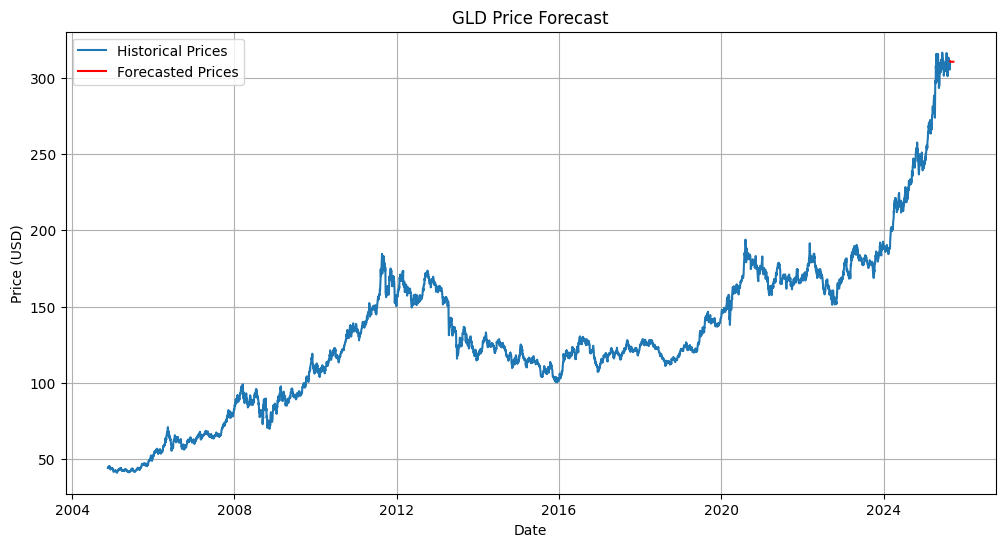

In [57]:
print(f"Fetching data for {COMMODITY}...")
raw_data = get_commodity_data(API_KEY, COMMODITY)

if raw_data:
    print("Preprocessing data...")
    commodity_df = preprocess_data(raw_data)

    if commodity_df is not None:
        print("Training model and forecasting...")
        model_summary, forecast_values = train_and_forecast(commodity_df, FORECAST_STEPS)

        if model_summary and forecast_values is not None:
            print("\n--- Model Summary ---")
            #print(model_summary.summary()) # Uncomment for detailed model stats

            print(f"\n--- Forecast for the next {FORECAST_STEPS} days ---")
            print(forecast_values)

            print("\nPlotting forecast...")
            plot_forecast(commodity_df, forecast_values)